<a href="https://colab.research.google.com/github/JINYUHOON/VIS_temp/blob/main/05_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

In [ ]:
!pip install albumentations

In [ ]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import math


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
from albumentations.augmentations.transforms import ShiftScaleRotate
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode =='train':
            self.transform = A.Compose([
                                   A.HorizontalFlip(p=0.5),
                                   A.ShiftScaleRotate(
                                       p = 0.5,
                                       shift_limit = 0.05,
                                       scale_limit = 0.05,
                                       rotate_limit = 15,
                                   ),
                                #    A.CoarseDropout(
                                #        p=0.5,
                                #        max_holes = 8,
                                #        max_height = int( 0.1 * size),
                                #        max_width = int( 0.1 * size)    
                                #    ),
                                   A.RandomBrightnessContrast(p=0.2),
            ])
    

    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [ ]:
base_path = '/content/drive/MyDrive/HOON/exam/OX/data/'

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.mode = mode
        self.image_size = image_size
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode =='val':
            self.df = self.df[self.df['fold'] == self.fold]

        # Remove invalid
        invalid_filenames = [
                             'Egyptian_Mau_14',
                             'Egyptian_Mau_139',
                             'Egyptian_Mau_145',
                             'Egyptian_Mau_156',
                             'Egyptian_Mau_167',
                             'Egyptian_Mau_177',
                             'Egyptian_Mau_186',
                             'Egyptian_Mau_1191',
                             'Abyssinian_5',
                             'Abyssinian_34',
                             'chihuahua_121',
                             'beagle_116'
                             
        ]

        self.df = self.df[-self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size , mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x = []
        batch_y = []

        for _ , r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(base_path + f'images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (self.image_size , self.image_size))

            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)

            image = image.astype('float32')
            image = image / 255.

            label = int(r['species']-1)

            batch_x.append(image)
            batch_y.append(label)

        return batch_x, batch_y

    def on_epoch_end(self):

        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [ ]:
csv_path = base_path + 'kfolds.csv'

train_generator = DataGenerator(batch_size = 128, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 256,
                                mode='train', 
                                shuffle=True)

valid_generator = DataGenerator(batch_size = 128, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 256,
                                mode='val', 
                                shuffle=True)

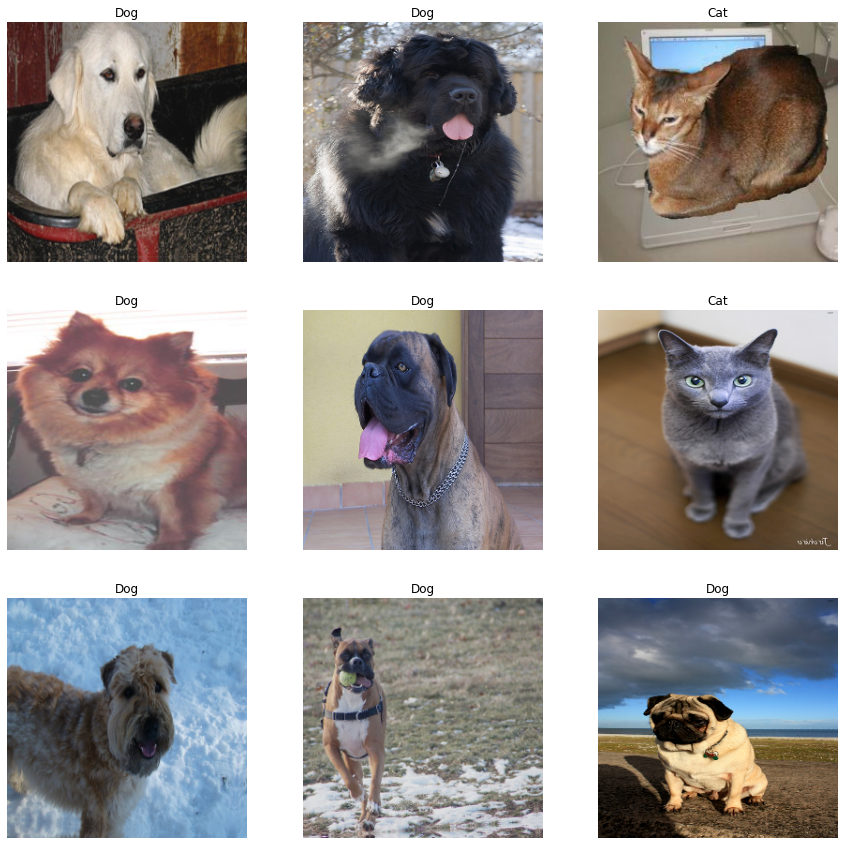

In [ ]:
import matplotlib.pyplot as plt

class_name = ['Cat','Dog']

for batch in train_generator:
    X,y = batch
    plt.figure(figsize=(15,15))

    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')

    break

In [ ]:
def get_sequential_model(input_shape):

    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),

            # 1st Conv
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),


            # 2nd Conv
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            # Classifier
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]   
    )

    return model

input_shape = (256,256,3)
model = get_sequential_model(input_shape)


model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

In [ ]:
history = model.fit(
        train_generator, 
        validation_data=valid_generator,
        epochs=10,
        verbose = 1)

Epoch 1/10
46/46 [==============================] - 2200s 48s/step - loss: 0.9116 - accuracy: 0.6343 - val_loss: 0.6582 - val_accuracy: 0.6780
Epoch 2/10
46/46 [==============================] - 65s 1s/step - loss: 0.6231 - accuracy: 0.6750 - val_loss: 0.6465 - val_accuracy: 0.6780
Epoch 3/10
46/46 [==============================] - 65s 1s/step - loss: 0.6135 - accuracy: 0.6728 - val_loss: 0.6595 - val_accuracy: 0.6794
Epoch 4/10
46/46 [==============================] - 65s 1s/step - loss: 0.5941 - accuracy: 0.6954 - val_loss: 0.6629 - val_accuracy: 0.6801
Epoch 5/10
46/46 [==============================] - 65s 1s/step - loss: 0.6036 - accuracy: 0.6849 - val_loss: 0.6516 - val_accuracy: 0.6780
Epoch 6/10
46/46 [==============================] - 65s 1s/step - loss: 0.6155 - accuracy: 0.6840 - val_loss: 0.6468 - val_accuracy: 0.6828
Epoch 7/10
46/46 [==============================] - 65s 1s/step - loss: 0.6075 - accuracy: 0.6842 - val_loss: 0.6497 - val_accuracy: 0.6943
Epoch 8/10
46/46 